In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
from torch.nn import init
from torchtext.legacy import data
from torchtext.vocab import Vectors
from torchtext.vocab import GloVe
import time
import nltk
from collections import defaultdict
import numpy as np

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Preprocessing


In [2]:
df=pd.read_csv('/content/train.tsv',sep='\t')
df.head()

,id,topic,score,text
0,636404876847656960,seinfeld,1,"Stay up late, watch Seinfeld, make Steve drive..."
1,641214034977628160,obama,-1,Y #FireBoehner? He fully funded Obama's #amnes...
2,640929313005682688,sarah palin,-1,Saturday Night Live is going to have to find a...
3,625865025585053697,kurt cobain,0,I hate Jon for making me watch the Kurt Cobain...
4,638976726597406720,nokia,1,OMG. It's the 15th birthday of the Nokia 3310....


In [4]:
from nltk.tokenize import word_tokenize

TEXT = data.Field(sequential=True, tokenize=word_tokenize, lower=True)
ASPECT = data.Field(sequential=False, lower=True)
LABEL = data.Field(sequential=False, use_vocab=False)

In [4]:
train, val, test = data.TabularDataset.splits(path='/content/',
                      skip_header=True,
                      train='train.tsv',
                      validation='val.tsv',
                      test='test.tsv',
                      format='tsv',
                      fields=[('id',LABEL),
                          ('topic', ASPECT),
                          ('score', LABEL),
                          ('text', TEXT)])

In [5]:
TEXT.build_vocab(train, val, test, vectors=GloVe(name='6B', dim=300))
ASPECT.build_vocab(train, val, test, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train, val, test)

In [6]:
TEXT.vocab.freqs.most_common(10)

[('the', 16721),
 ('.', 14365),
 (':', 10298),
 (',', 9779),
 ('to', 9161),
 ('@', 7707),
 ('i', 7352),
 ('a', 6119),
 ('in', 5931),
 ('!', 5764)]

In [7]:
print(TEXT.vocab.vectors.shape)
print(ASPECT.vocab.vectors.shape)

torch.Size([40911, 300])
torch.Size([177, 300])


In [8]:
batch_size=64
device = torch.device('cuda:0')

train_iter = data.Iterator(dataset=train, batch_size=batch_size, shuffle=True, sort_within_batch=False, repeat=False, device=device)
val_iter = data.Iterator(dataset=val, batch_size=batch_size, repeat=False, device=device)
test_iter = data.Iterator(dataset=test, batch_size=batch_size, repeat=False, device=device)

In [9]:
text_vocab_size = len(TEXT.vocab)
aspect_vocab_size = len(ASPECT.vocab)
text_vector=TEXT.vocab.vectors
aspect_vector=ASPECT.vocab.vectors

In [10]:
batch = next(iter(train_iter))
print(batch.text.shape)#(seq_len,batch_size)
print(batch.topic.shape)
print(batch.score.shape)

torch.Size([34, 64])
torch.Size([64])
torch.Size([64])


## Model

In [13]:
class ATAE_LSTM(nn.Module):
  def __init__(self, embedding_dim, num_hiddens, num_layers):
    super(ATAE_LSTM, self).__init__()
    self.text_embeddings = nn.Embedding(text_vocab_size, embedding_dim)
    self.aspect_embeddings = nn.Embedding(aspect_vocab_size, embedding_dim)
    self.text_embeddings = nn.Embedding.from_pretrained(text_vector,freeze=False)
    self.aspect_embeddings = nn.Embedding.from_pretrained(aspect_vector,freeze=False)
    self.lstm = nn.LSTM(input_size=2 * embedding_dim,
              hidden_size=num_hiddens,
              num_layers=num_layers,
              batch_first=True,
              bidirectional=True)
    self.wh = nn.Parameter(torch.Tensor(num_hiddens * 2, num_hiddens * 2))
    self.wv = nn.Parameter(torch.Tensor(embedding_dim, embedding_dim))
    self.omega = nn.Parameter(torch.Tensor(1, embedding_dim*2))
    self.wp = nn.Parameter(torch.Tensor(num_hiddens * 2, num_hiddens * 2))
    self.wx = nn.Parameter(torch.Tensor(num_hiddens * 2, num_hiddens * 2))
    self.ws = nn.Parameter(torch.Tensor(5, num_hiddens * 2))
    nn.init.uniform_(self.wh, -0.1, 0.1)
    nn.init.uniform_(self.wv, -0.1, 0.1)
    nn.init.uniform_(self.omega, -0.1, 0.1)
    nn.init.uniform_(self.wp, -0.1, 0.1)
    nn.init.uniform_(self.wx, -0.1, 0.1)
    nn.init.uniform_(self.ws, -0.1, 0.1)
    self.bs = nn.Parameter(torch.zeros((5, 1)))

  def forward(self, text, aspect):
    seq_len = len(text.t())
    e1 = self.text_embeddings(text)
    e2 = self.aspect_embeddings(aspect).expand(e1.size())
    wv = torch.cat((e1, e2), dim=2)
    out, (h, c) = self.lstm(wv)  # output, (h, c)

    H = out.permute(0, 2, 1)
    #print(H.shape)
    #print(self.wh.shape)

    Wh_H = torch.matmul(self.wh, H)
    #print('Wh_H: ', Wh_H.shape)
    Wv_Va_eN = torch.matmul(
        self.wv,
        self.aspect_embeddings(aspect).permute(0, 2, 1).expand(-1, embedding_dim, seq_len))
    #print('Wv_Va_eN: ', Wv_Va_eN.shape)

    vh = torch.cat((Wh_H, Wv_Va_eN), dim=1)
    #print('vh: ', vh.shape)

    M = torch.tanh(vh)
    #print('M: ', M.shape)

    alpha = F.softmax(torch.matmul(self.omega, M),dim=2)
    #print('alpha: ', alpha.shape)

    r = torch.matmul(H, alpha.permute(0, 2, 1))
    #print('r: ', r.shape)

    h_star = torch.tanh(
        torch.matmul(self.wp, r) +
        torch.matmul(self.wx, torch.unsqueeze(H[:, :, -1], 2)))
    #print('h_star: ', h_star.shape)

    y = torch.matmul(self.ws, h_star) + self.bs
    
    y = y.reshape([-1, 5])
    #print('y: ', y.shape)

    return y

In [14]:
embedding_dim, num_hiddens, num_layers = 300, 150, 1
net = ATAE_LSTM(embedding_dim, num_hiddens, num_layers)
net = net.to(device)
print(net)

ATAE_LSTM(
  (text_embeddings): Embedding(40911, 300)
  (aspect_embeddings): Embedding(177, 300)
  (lstm): LSTM(600, 150, batch_first=True, bidirectional=True)
)


## Train

In [15]:
def evaluate_accuracy(data_iter, net, loss):
  acc_sum, n = 0.0, 0
  loss_sum = 0
  batch_count = 0
  with torch.no_grad():
    for batch_idx, batch in enumerate(data_iter):
      X1, X2, y = batch.text, batch.topic, batch.score.to(device)
      X1 = X1.permute(1, 0).to(device)
      X2 = X2.unsqueeze(1).to(device)
      y.data.add_(2)

      if isinstance(net, torch.nn.Module):
        net.eval()
        y_hat = net(X1,X2)
        acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()
        net.train()
      else:
        if ('is_training' in net.__code__.co_varnames):
          yhat = net(X1, X2, is_training=False)
          acc_sum += (yhat.argmax(dim=1) == y).float().sum().item()
        else:
          y_hat = net(X1,X2)
          acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()

      n += y.shape[0]
      loss_sum += loss(y_hat, y).item()
      batch_count += 1
  return acc_sum/n, loss_sum/batch_count

In [16]:
def train(train_iter, test_iter, net, loss, optimizer, num_epochs):
    history = defaultdict(list)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for batch_idx, batch in enumerate(train_iter):
            X1, X2, y = batch.text, batch.topic, batch.score.to(device)
            X1 = X1.permute(1, 0).to(device)
            X2 = X2.unsqueeze(1).to(device)
            y.data.add_(2)
            y_hat = net(X1,X2)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            batch_count += 1
        val_acc,val_loss = evaluate_accuracy(test_iter, net, loss)

        history['train_acc'].append(train_acc_sum / n)
        history['train_loss'].append(train_l_sum / batch_count)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(
            'epoch %d, train loss %.4f, train acc %.3f, val loss %.4f, val acc %.3f, time %.1f sec'
            % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n,
               val_loss,val_acc, time.time() - start))
    return history

In [17]:
lr, num_epochs = 0.01, 50
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss().to(device)
history = train(train_iter, val_iter, net, loss, optimizer, num_epochs)

epoch 1, train loss 1.2474, train acc 0.511, val loss 1.2310, val acc 0.487, time 3.4 sec
epoch 2, train loss 0.5002, train acc 0.586, val loss 1.2431, val acc 0.509, time 3.3 sec
epoch 3, train loss 0.2222, train acc 0.753, val loss 1.4823, val acc 0.471, time 3.3 sec
epoch 4, train loss 0.0738, train acc 0.902, val loss 1.9174, val acc 0.478, time 3.3 sec
epoch 5, train loss 0.0261, train acc 0.958, val loss 2.3464, val acc 0.473, time 3.3 sec
epoch 6, train loss 0.0096, train acc 0.981, val loss 2.7779, val acc 0.477, time 3.3 sec
epoch 7, train loss 0.0057, train acc 0.986, val loss 3.0308, val acc 0.468, time 3.3 sec
epoch 8, train loss 0.0035, train acc 0.991, val loss 2.9816, val acc 0.470, time 3.3 sec
epoch 9, train loss 0.0029, train acc 0.992, val loss 3.1321, val acc 0.480, time 3.3 sec
epoch 10, train loss 0.0025, train acc 0.992, val loss 3.3045, val acc 0.490, time 3.3 sec
epoch 11, train loss 0.0033, train acc 0.989, val loss 3.0245, val acc 0.466, time 3.3 sec
epoch 12

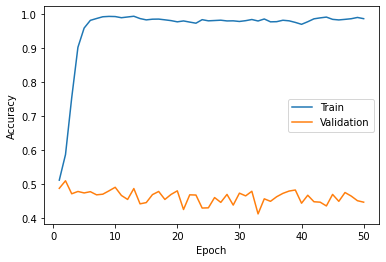

In [19]:
import numpy as np
import matplotlib.pyplot as plt

epochNum = np.arange(1,51)
train_acc = history['train_acc']
val_acc = history['val_acc']
plt.plot(epochNum, train_acc, label='Train')
plt.plot(epochNum, val_acc, label='Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy") 
plt.legend()

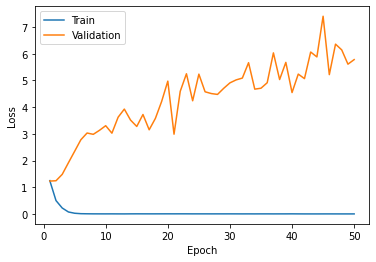

In [20]:
train_loss = history['train_loss']
val_loss = history['val_loss']
plt.plot(epochNum, train_loss, label='Train')
plt.plot(epochNum, val_loss, label='Validation')
plt.xlabel("Epoch") 
plt.ylabel("Loss") 
plt.legend()

In [27]:
test_acc,_ = evaluate_accuracy(test_iter, net, loss)
print(test_acc)

0.39267057783492726


## Experiment with merge data

In [5]:
train, val, test = data.TabularDataset.splits(path='/content/',
                      skip_header=True,
                      train='merge_train.tsv',
                      validation='merge_val.tsv',
                      test='merge_test.tsv',
                      format='tsv',
                      fields=[('id',LABEL),
                          ('topic', ASPECT),
                          ('score', LABEL),
                          ('text', TEXT)])

In [6]:
TEXT.build_vocab(train, val, test, vectors=GloVe(name='6B', dim=300))
ASPECT.build_vocab(train, val, test, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train, val, test)

In [7]:
TEXT.vocab.freqs.most_common(10)

[('the', 16721),
 ('.', 14365),
 (':', 10298),
 (',', 9779),
 ('to', 9161),
 ('@', 7707),
 ('i', 7352),
 ('a', 6119),
 ('in', 5931),
 ('!', 5764)]

In [8]:
print(TEXT.vocab.vectors.shape)
print(ASPECT.vocab.vectors.shape)

torch.Size([40911, 300])
torch.Size([177, 300])


In [9]:
batch_size=64
device = torch.device('cuda:0')

train_iter = data.Iterator(dataset=train, batch_size=batch_size, shuffle=True, sort_within_batch=False, repeat=False, device=device)
val_iter = data.Iterator(dataset=val, batch_size=batch_size, repeat=False, device=device)
test_iter = data.Iterator(dataset=test, batch_size=batch_size, repeat=False, device=device)

In [10]:
text_vocab_size = len(TEXT.vocab)
aspect_vocab_size = len(ASPECT.vocab)
text_vector=TEXT.vocab.vectors
aspect_vector=ASPECT.vocab.vectors

In [11]:
batch = next(iter(train_iter))
print(batch.text.shape)#(seq_len,batch_size)
print(batch.topic.shape)
print(batch.score.shape)

torch.Size([37, 64])
torch.Size([64])
torch.Size([64])


In [17]:
lr, num_epochs = 0.01, 50
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss().to(device)
history = train(train_iter, val_iter, net, loss, optimizer, num_epochs)

epoch 1, train loss 1.0732, train acc 0.527, val loss 1.0396, val acc 0.506, time 9.2 sec
epoch 2, train loss 0.5118, train acc 0.550, val loss 1.0338, val acc 0.549, time 9.0 sec
epoch 3, train loss 0.3464, train acc 0.549, val loss 1.1392, val acc 0.543, time 9.0 sec
epoch 4, train loss 0.2594, train acc 0.582, val loss 1.0861, val acc 0.516, time 9.0 sec
epoch 5, train loss 0.2038, train acc 0.587, val loss 1.1826, val acc 0.535, time 9.0 sec
epoch 6, train loss 0.1657, train acc 0.613, val loss 1.2531, val acc 0.557, time 9.0 sec
epoch 7, train loss 0.1360, train acc 0.627, val loss 1.1890, val acc 0.534, time 9.0 sec
epoch 8, train loss 0.1159, train acc 0.642, val loss 1.1443, val acc 0.531, time 9.0 sec
epoch 9, train loss 0.0999, train acc 0.654, val loss 1.1866, val acc 0.535, time 9.0 sec
epoch 10, train loss 0.0898, train acc 0.655, val loss 1.1451, val acc 0.528, time 9.0 sec
epoch 11, train loss 0.0791, train acc 0.666, val loss 1.2951, val acc 0.496, time 9.0 sec
epoch 12

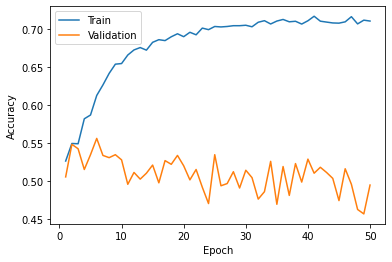

In [18]:
import matplotlib.pyplot as plt

epochNum = np.arange(1,51)
train_acc = history['train_acc']
val_acc = history['val_acc']
plt.plot(epochNum, train_acc, label='Train')
plt.plot(epochNum, val_acc, label='Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy") 
plt.legend()

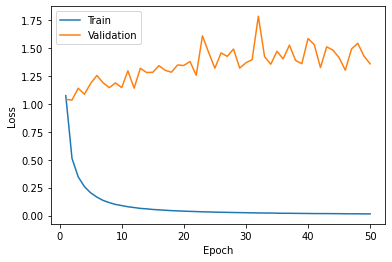

In [19]:
train_loss = history['train_loss']
val_loss = history['val_loss']
plt.plot(epochNum, train_loss, label='Train')
plt.plot(epochNum, val_loss, label='Validation')
plt.xlabel("Epoch") 
plt.ylabel("Loss") 
plt.legend()

In [21]:
test_acc,_ = evaluate_accuracy(test_iter, net, loss)
print(test_acc)

0.4922027290448343
